In [3]:
!pip install tensorboardX
!pip install d2l==0.17.0

     |████████████████████████████████| 124 kB 4.9 MB/s 
     |████████████████████████████████| 83 kB 1.2 MB/s 


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter
from d2l import torch as d2l

#Prepare dataset

In [5]:
# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 32

# convert data to torch.FloatTensor
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# prepare data loader
data_loader = torch.utils.data.DataLoader(MNIST('data', train=True, download=True, transform=transform),
                                          batch_size=batch_size, shuffle=True,  num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



#Visualize the data

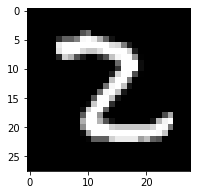

In [6]:
# obtain one batch of training images
dataiter = iter(data_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

#Define the model


##Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

##Generator

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [9]:
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

##Train the Generator

In [13]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()

    Z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(Z, fake_labels)

    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

##Train the Discriminator

In [10]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    
    #real loss
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())

    #fake loss
    Z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(Z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

##Training Process

In [11]:
def train(discriminator, generator, data_loader, num_epochs, lr, device = d2l.try_gpu()):
    #set parameter
    for w in discriminator.parameters():
        nn.init.normal_(w, 0, 0.01)
    for w in generator.parameters():
        nn.init.normal_(w, 0, 0.01)
    discriminator, generator = discriminator.to(device), generator.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.9, 0.999]}
    # trainer_hp = {'lr': lr}
    d_optimizer = torch.optim.Adam(discriminator.parameters(), **trainer_hp)
    g_optimizer = torch.optim.Adam(generator.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs], legend=['discriminator', 'generator'])

    for epoch in range(1, num_epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)     #d_loss, g_loss, num_examples
        for i, (images, labels) in enumerate(data_loader):
            real_images = Variable(images).cuda()
            labels = Variable(labels).cuda()
            generator.train()
            d_loss = discriminator_train_step(len(real_images), discriminator, generator,
                                              d_optimizer, criterion, real_images, labels)
            g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
            metric.add(d_loss, g_loss, batch_size)
        

        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

loss_D 0.040, loss_G 0.027, 1393.4 examples/sec on cuda:0


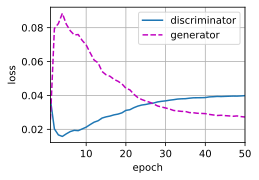

In [14]:
lr, num_epochs = 1e-4, 50
train(discriminator, generator, data_loader, num_epochs, lr)

In [15]:
torch.save(generator.state_dict(), 'generator_state.pt')

(-0.5, 301.5, 301.5, -0.5)

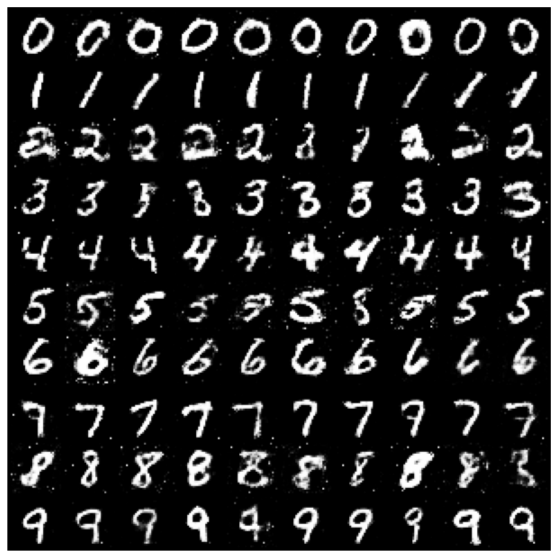

In [17]:
z = Variable(torch.randn(100, 100)).cuda()
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()
images = generator(z, labels).unsqueeze(1)
grid = make_grid(images, nrow=10, normalize=True)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.cpu().permute(1, 2, 0).data, cmap='binary')
ax.axis('off')

#Generate fake images with labels

In [22]:
def generate_digit(generator, digit):
    z = Variable(torch.randn(1, 100)).cuda()
    label = torch.LongTensor([digit]).cuda()
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)
    
generate_digit(generator, 8)
